In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [12]:
def load_data():
    print("Loading the lifestyle monitoring dataset...")
    df = pd.read_csv("data/lifestyle_monitoring.csv")
    print(f"Original dataset shape: {df.shape}")
    return df


In [13]:
# Task 1: Handling Missing Data
def handle_missing_data(df):
    print("\n--- Task 1: Handling Missing Data ---")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df) * 100).round(2)
    
    print("Missing values in each column:")
    for col in df.columns:
        if missing_values[col] > 0:
            print(f"{col}: {missing_values[col]} ({missing_percentage[col]}%)")
    
    # Strategy 1: Fill missing Step_Count with the user's mean
    print("\nFilling missing Step_Count with each user's mean...")
    df['Step_Count'] = df.groupby('User_ID')['Step_Count'].transform(lambda x: x.fillna(x.mean()))
    
    # Strategy 2: Fill remaining Step_Count with global median
    step_median = df['Step_Count'].median()
    df['Step_Count'] = df['Step_Count'].fillna(step_median)
    
    # Strategy 3: Fill missing Sleep_Duration with the user's median
    print("Filling missing Sleep_Duration with each user's median...")
    df['Sleep_Duration'] = df.groupby('User_ID')['Sleep_Duration'].transform(lambda x: x.fillna(x.median()))
    
    # Strategy 4: Fill remaining Sleep_Duration with global median
    sleep_median = df['Sleep_Duration'].median()
    df['Sleep_Duration'] = df['Sleep_Duration'].fillna(sleep_median)
    
    # Strategy 5: Fill missing Heart_Rate with the user's median
    print("Filling missing Heart_Rate with each user's median...")
    df['Heart_Rate'] = df.groupby('User_ID')['Heart_Rate'].transform(lambda x: x.fillna(x.median()))
    
    # Strategy 6: Fill remaining Heart_Rate with global median
    heart_rate_median = df['Heart_Rate'].median()
    df['Heart_Rate'] = df['Heart_Rate'].fillna(heart_rate_median)
    
    # Strategy 7: Fill missing Calories_Burned with a regression model based on Step_Count
    # First check if there are any missing values in Calories_Burned
    if df['Calories_Burned'].isnull().sum() > 0:
        print("Predicting missing Calories_Burned using regression on Step_Count...")
        
        # Create a simple linear regression using the available data
        from sklearn.linear_model import LinearRegression
        
        # Prepare data for modeling
        X_train = df.dropna(subset=['Calories_Burned'])[['Step_Count']].values
        y_train = df.dropna(subset=['Calories_Burned'])['Calories_Burned'].values
        
        # Train the model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Identify rows with missing Calories_Burned
        missing_calories_idx = df['Calories_Burned'].isnull()
        
        if missing_calories_idx.sum() > 0:
            # Predict missing values
            X_predict = df.loc[missing_calories_idx, ['Step_Count']].values
            df.loc[missing_calories_idx, 'Calories_Burned'] = model.predict(X_predict).round(0)
    
    # Strategy 8: Fill remaining Calories_Burned with global median
    calories_median = df['Calories_Burned'].median()
    df['Calories_Burned'] = df['Calories_Burned'].fillna(calories_median)
    
    # Strategy 9: Fill missing Activity_Level based on Step_Count
    if df['Activity_Level'].isnull().sum() > 0:
        print("Inferring missing Activity_Level based on Step_Count...")
        
        # Function to determine activity level from step count
        def infer_activity_level(step_count):
            if pd.isnull(step_count):
                return None
            elif step_count < 5000:
                return "Sedentary"
            elif step_count < 7500:
                return "Lightly Active"
            elif step_count < 10000:
                return "Active"
            else:
                return "Very Active"
        
        # Apply the function to rows with missing Activity_Level
        missing_activity_idx = df['Activity_Level'].isnull()
        df.loc[missing_activity_idx, 'Activity_Level'] = df.loc[missing_activity_idx, 'Step_Count'].apply(infer_activity_level)
    
    # Strategy 10: Fill any remaining missing Activity_Level with mode
    activity_mode = df['Activity_Level'].mode()[0]
    df['Activity_Level'] = df['Activity_Level'].fillna(activity_mode)
    
    # Check if any missing values remain
    missing_after = df.isnull().sum()
    print("\nMissing values after handling:")
    print(missing_after)
    
    return df


In [14]:
def standardize_device_types(df):
    print("\n--- Task 2: Data Cleaning & Standardization ---")
    
    # Check unique values in Device_Type before standardization
    print("Unique Device_Type values before standardization:")
    print(df['Device_Type'].unique())
    
    # Create a mapping dictionary for standardization
    device_mapping = {
        'FitBit': 'Fitbit', 'fitbit': 'Fitbit', 'FITBIT': 'Fitbit',
        'Apple Watch': 'Apple Watch', 'apple watch': 'Apple Watch', 'APPLE WATCH': 'Apple Watch',
        'Samsung': 'Samsung', 'samsung': 'Samsung', 'SAMSUNG': 'Samsung',
        'Garmin': 'Garmin', 'garmin': 'Garmin', 'GARMIN': 'Garmin'
    }
    
    # Apply the mapping to standardize device names
    df['Device_Type'] = df['Device_Type'].map(device_mapping)
    
    # Check unique values after standardization
    print("\nUnique Device_Type values after standardization:")
    print(df['Device_Type'].unique())
    
    return df

# Task 3: Removing Duplicates
def remove_duplicates(df):
    print("\n--- Task 3: Removing Duplicates ---")
    
    # Count initial records
    initial_count = len(df)
    print(f"Initial record count: {initial_count}")
    
    # Check for duplicates based on User_ID and Date
    duplicates = df.duplicated(subset=['User_ID', 'Date'], keep=False)
    duplicate_count = duplicates.sum()
    print(f"Found {duplicate_count} duplicate records based on User_ID and Date")
    
    if duplicate_count > 0:
        # Display some examples of duplicates
        print("\nSample duplicate records:")
        duplicate_sample = df[duplicates].head(6)
        print(duplicate_sample)
        
        # Remove duplicates, keeping the first occurrence
        df = df.drop_duplicates(subset=['User_ID', 'Date'], keep='first')
        
        # Count records after removing duplicates
        final_count = len(df)
        print(f"\nRemoved {initial_count - final_count} duplicate records")
        print(f"Record count after removing duplicates: {final_count}")
    
    return df

In [15]:
# Task 4: Outlier Detection
def handle_outliers(df):
    print("\n--- Task 4: Outlier Detection ---")
    
    # Check for Heart_Rate outliers using IQR method
    q1_hr = df['Heart_Rate'].quantile(0.25)
    q3_hr = df['Heart_Rate'].quantile(0.75)
    iqr_hr = q3_hr - q1_hr
    
    lower_bound_hr = q1_hr - (1.5 * iqr_hr)
    upper_bound_hr = q3_hr + (1.5 * iqr_hr)
    
    # Identify heart rate outliers
    hr_outliers = df[(df['Heart_Rate'] < lower_bound_hr) | (df['Heart_Rate'] > upper_bound_hr)]
    hr_outlier_count = len(hr_outliers)
    
    print(f"Heart Rate IQR: {iqr_hr}")
    print(f"Heart Rate bounds: [{lower_bound_hr}, {upper_bound_hr}]")
    print(f"Detected {hr_outlier_count} Heart_Rate outliers")
    
    if hr_outlier_count > 0:
        # Show some examples of heart rate outliers
        print("\nSample Heart_Rate outliers:")
        print(hr_outliers[['User_ID', 'Date', 'Heart_Rate']].head())
        
        # Strategy: Cap extreme heart rate values at upper/lower bounds
        print("\nCapping extreme Heart_Rate values...")
        df['Heart_Rate'] = df['Heart_Rate'].clip(lower=lower_bound_hr, upper=upper_bound_hr)
    
    # Check for Step_Count outliers using IQR method
    q1_steps = df['Step_Count'].quantile(0.25)
    q3_steps = df['Step_Count'].quantile(0.75)
    iqr_steps = q3_steps - q1_steps
    
    lower_bound_steps = q1_steps - (1.5 * iqr_steps)
    upper_bound_steps = q3_steps + (1.5 * iqr_steps)
    
    # Identify step count outliers
    steps_outliers = df[(df['Step_Count'] < lower_bound_steps) | (df['Step_Count'] > upper_bound_steps)]
    steps_outlier_count = len(steps_outliers)
    
    print(f"\nStep Count IQR: {iqr_steps}")
    print(f"Step Count bounds: [{lower_bound_steps}, {upper_bound_steps}]")
    print(f"Detected {steps_outlier_count} Step_Count outliers")
    
    if steps_outlier_count > 0:
        # Show some examples of step count outliers
        print("\nSample Step_Count outliers:")
        print(steps_outliers[['User_ID', 'Date', 'Step_Count']].head())
        
        # Strategy: Cap extreme step count values at upper/lower bounds
        print("\nCapping extreme Step_Count values...")
        df['Step_Count'] = df['Step_Count'].clip(lower=max(0, lower_bound_steps), upper=upper_bound_steps)
    
    # Verify outliers were handled
    hr_extreme_after = df[(df['Heart_Rate'] < lower_bound_hr) | (df['Heart_Rate'] > upper_bound_hr)]
    steps_extreme_after = df[(df['Step_Count'] < lower_bound_steps) | (df['Step_Count'] > upper_bound_steps)]
    
    print(f"\nHeart_Rate values outside bounds after capping: {len(hr_extreme_after)}")
    print(f"Step_Count values outside bounds after capping: {len(steps_extreme_after)}")
    
    return df

In [16]:
# Task 5: Data Transformation
def transform_categorical_data(df):
    print("\n--- Task 5: Data Transformation ---")
    
    # Display unique Activity_Level categories
    print("Unique Activity_Level categories:")
    print(df['Activity_Level'].unique())
    
    # Method 1: Label Encoding
    label_encoder = LabelEncoder()
    df['Activity_Level_Label'] = label_encoder.fit_transform(df['Activity_Level'])
    
    # Display mapping
    activity_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("\nLabel Encoding Mapping:")
    for activity, code in activity_mapping.items():
        print(f"{activity} -> {code}")
    
    # Method 2: One-Hot Encoding
    # Create dummy variables for Activity_Level
    activity_dummies = pd.get_dummies(df['Activity_Level'], prefix='Activity')
    
    # Join the dummy columns back to the main dataframe
    df = pd.concat([df, activity_dummies], axis=1)
    
    print("\nColumns after one-hot encoding:")
    print(df.columns.tolist())
    
    return df


In [17]:
# Task 6: Data Merging
def merge_datasets(df):
    print("\n--- Task 6: Data Merging ---")
    
    # Load demographics dataset
    demographics = pd.read_csv("./data/user_demographics.csv")
    print(f"Demographics dataset shape: {demographics.shape}")
    print("\nSample of demographics data:")
    print(demographics.head())
    
    # Check for missing values in demographics dataset
    demo_missing = demographics.isnull().sum()
    if demo_missing.sum() > 0:
        print("\nMissing values in demographics dataset:")
        for col in demographics.columns:
            if demo_missing[col] > 0:
                print(f"{col}: {demo_missing[col]} missing values")
        
        # Fill missing Age with median
        demographics['Age'] = demographics['Age'].fillna(demographics['Age'].median())
        
        # Fill missing Gender with mode
        demographics['Gender'] = demographics['Gender'].fillna(demographics['Gender'].mode()[0])
        
        # Fill missing BMI with median
        demographics['BMI'] = demographics['BMI'].fillna(demographics['BMI'].median())
        
        print("\nMissing values after handling:")
        print(demographics.isnull().sum())
    
    # Merge with the main dataset on User_ID
    merged_df = pd.merge(df, demographics, on='User_ID', how='left')
    
    # Check for any users without demographic information
    missing_demographics = merged_df[merged_df['Age'].isna()]['User_ID'].nunique()
    print(f"\nUsers without demographic information: {missing_demographics}")
    
    # Check the merged dataset
    print(f"Merged dataset shape: {merged_df.shape}")
    print("\nSample of merged data:")
    print(merged_df.head())
    
    return merged_df

In [18]:
def prepare_final_dataset(df):
    print("\n--- Task 7: Final Dataset Preparation ---")
    
    # Select relevant columns for the final dataset
    # Includes original columns plus the encoded activity levels but excludes the original Activity_Level
    final_columns = [col for col in df.columns if col != 'Activity_Level' or not col.startswith('Activity_')] + \
                     [col for col in df.columns if col.startswith('Activity_')]
    
    final_df = df.copy()
    
    # Additional preparation steps:
    # 1. Convert Step_Count to integer
    final_df['Step_Count'] = final_df['Step_Count'].astype(int)
    
    # 2. Round Sleep_Duration to one decimal place
    final_df['Sleep_Duration'] = final_df['Sleep_Duration'].round(1)
    
    # 3. Convert Heart_Rate to integer
    final_df['Heart_Rate'] = final_df['Heart_Rate'].astype(int)
    
    # 4. Convert Calories_Burned to integer
    final_df['Calories_Burned'] = final_df['Calories_Burned'].astype(int)
    
    # 5. Create derived features
    # Steps per Calorie
    final_df['Steps_Per_Calorie'] = (final_df['Step_Count'] / final_df['Calories_Burned']).round(3)
    
    # Steps per BMI unit (as a fitness efficiency metric)
    final_df['Steps_Per_BMI'] = (final_df['Step_Count'] / final_df['BMI']).round(1)
    
    # Sleep efficiency (sleep duration relative to calories burned)
    final_df['Sleep_Efficiency'] = (final_df['Sleep_Duration'] / (final_df['Calories_Burned'] / 1000)).round(2)
    
    # Final dataset summary
    print("\nFinal dataset info:")
    print(final_df.info())
    
    print("\nFinal dataset descriptive statistics:")
    print(final_df.describe())
    
    # Save the final cleaned dataset
    final_df.to_csv("data/lifestyle_monitoring_cleaned.csv", index=False)
    print("\nFinal cleaned dataset saved to: data/lifestyle_monitoring_cleaned.csv")
    
    return final_df

In [19]:
def main():
    # Load the data
    df = load_data()
    
    # Execute each task
    df = handle_missing_data(df)
    df = standardize_device_types(df)
    df = remove_duplicates(df)
    df = handle_outliers(df)
    df = transform_categorical_data(df)
    df = merge_datasets(df)
    final_df = prepare_final_dataset(df)
    
    print("\nData wrangling complete!")
    
if __name__ == "__main__":
    main() 

Loading the lifestyle monitoring dataset...
Original dataset shape: (3090, 8)

--- Task 1: Handling Missing Data ---
Missing values in each column:
Step_Count: 3 (0.1%)
Heart_Rate: 5 (0.16%)
Calories_Burned: 5 (0.16%)
Activity_Level: 10 (0.32%)

Filling missing Step_Count with each user's mean...
Filling missing Sleep_Duration with each user's median...
Filling missing Heart_Rate with each user's median...
Predicting missing Calories_Burned using regression on Step_Count...
Inferring missing Activity_Level based on Step_Count...

Missing values after handling:
User_ID            0
Date               0
Step_Count         0
Heart_Rate         0
Sleep_Duration     0
Calories_Burned    0
Activity_Level     0
Device_Type        0
dtype: int64

--- Task 2: Data Cleaning & Standardization ---
Unique Device_Type values before standardization:
['Apple Watch' 'fitbit' 'GARMIN' 'FitBit' 'FITBIT' 'APPLE WATCH' 'Garmin'
 'garmin' 'SAMSUNG' 'apple watch' 'Samsung' 'samsung']

Unique Device_Type valu

### Data Visualization

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Load the cleaned dataset
cleaned_df = pd.read_csv("data/lifestyle_monitoring_cleaned.csv")

# Create a directory for visualizations
import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

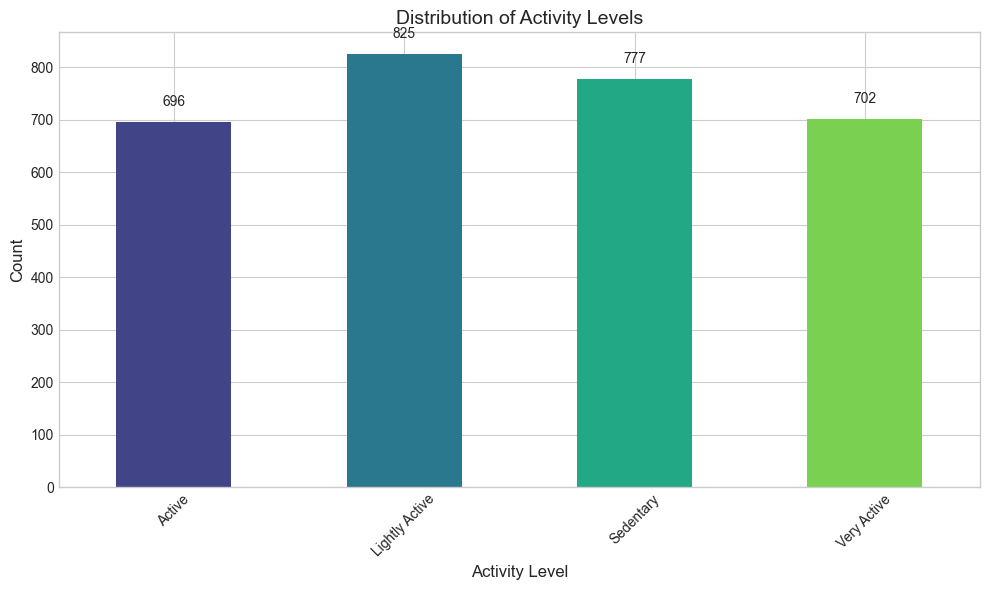

<Figure size 640x480 with 0 Axes>

In [21]:
# 1. Activity Level Distribution
plt.figure(figsize=(10, 6))
activity_counts = cleaned_df['Activity_Level'].value_counts().sort_index()
ax = activity_counts.plot(kind='bar', color=sns.color_palette("viridis", 4))
plt.title('Distribution of Activity Levels', fontsize=14)
plt.xlabel('Activity Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
for i, v in enumerate(activity_counts):
    ax.text(i, v + 30, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()
plt.savefig('visualizations/activity_distribution.png', dpi=300)

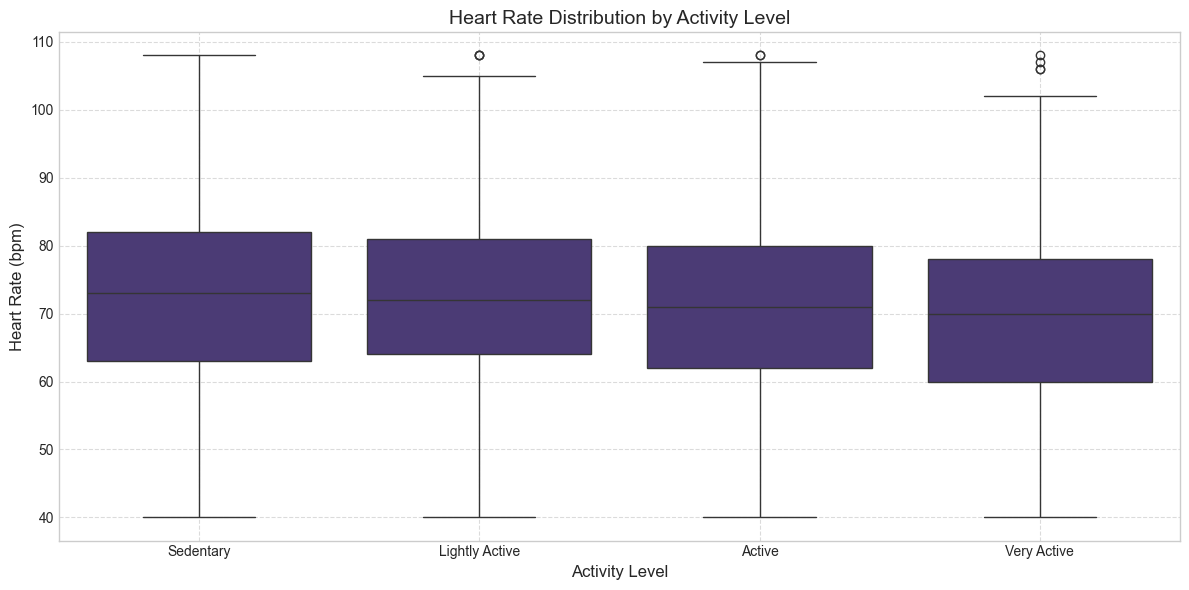

<Figure size 640x480 with 0 Axes>

In [22]:
# 2. Heart Rate by Activity Level
plt.figure(figsize=(12, 6))
sns.boxplot(x='Activity_Level', y='Heart_Rate', data=cleaned_df, order=['Sedentary', 'Lightly Active', 'Active', 'Very Active'])
plt.title('Heart Rate Distribution by Activity Level', fontsize=14)
plt.xlabel('Activity Level', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('visualizations/heart_rate_by_activity.png', dpi=300)

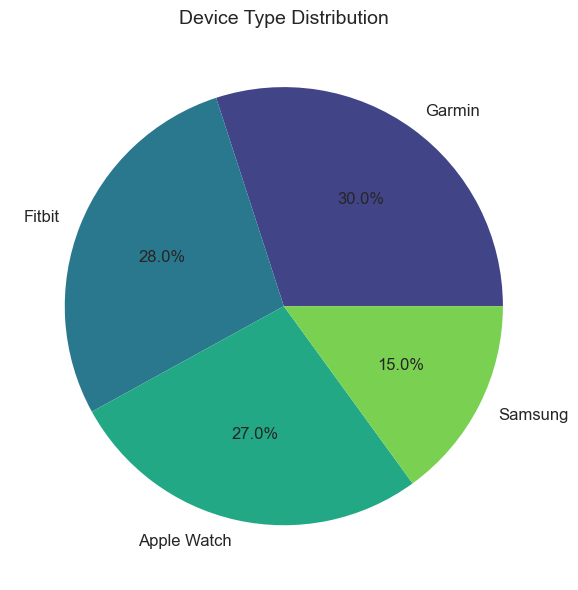

<Figure size 640x480 with 0 Axes>

In [23]:
# 3. Device Type Distribution
plt.figure(figsize=(10, 6))
device_counts = cleaned_df['Device_Type'].value_counts()
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', 
        textprops={'fontsize': 12}, colors=sns.color_palette("viridis", len(device_counts)))
plt.title('Device Type Distribution', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig('visualizations/device_distribution.png', dpi=300)

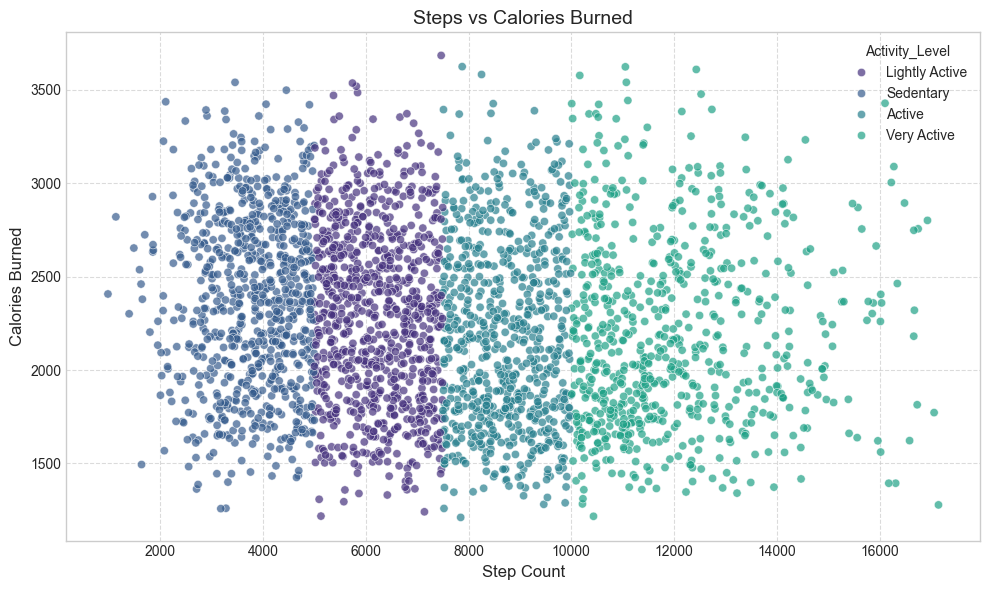

<Figure size 640x480 with 0 Axes>

In [24]:
# 4. Steps vs Calories Burned Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Step_Count', y='Calories_Burned', hue='Activity_Level', 
                data=cleaned_df, alpha=0.7)
plt.title('Steps vs Calories Burned', fontsize=14)
plt.xlabel('Step Count', fontsize=12)
plt.ylabel('Calories Burned', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('visualizations/steps_vs_calories.png', dpi=300)

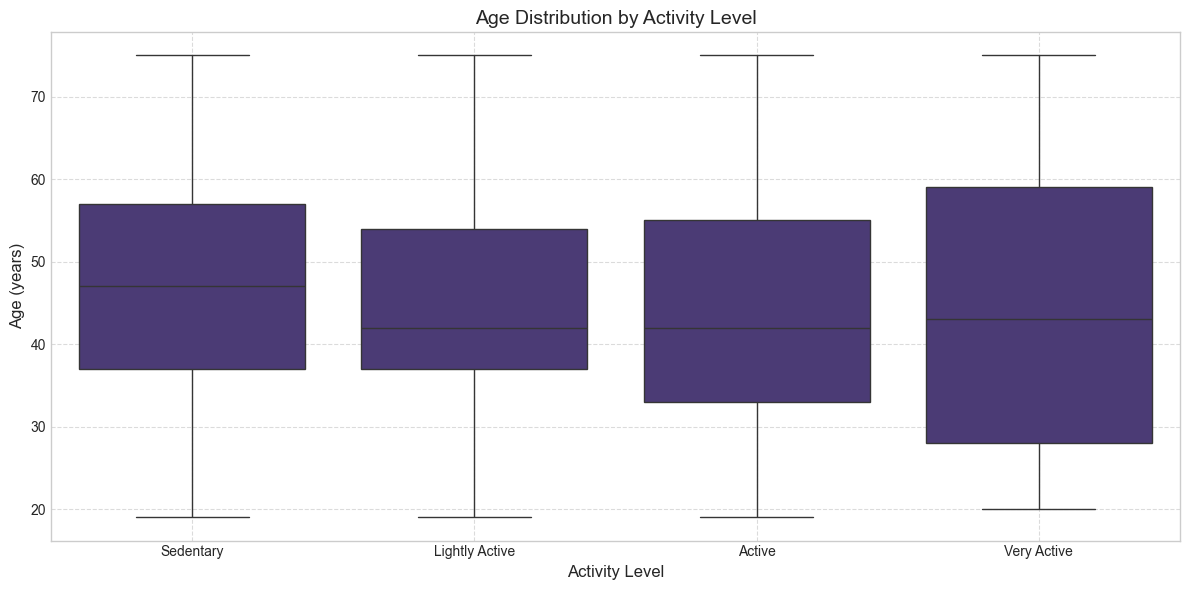

In [25]:
# 5. Age vs Activity Level
plt.figure(figsize=(12, 6))
sns.boxplot(x='Activity_Level', y='Age', data=cleaned_df, order=['Sedentary', 'Lightly Active', 'Active', 'Very Active'])
plt.title('Age Distribution by Activity Level', fontsize=14)
plt.xlabel('Activity Level', fontsize=12)
plt.ylabel('Age (years)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/age_by_activity.png', dpi=300)
plt.show()

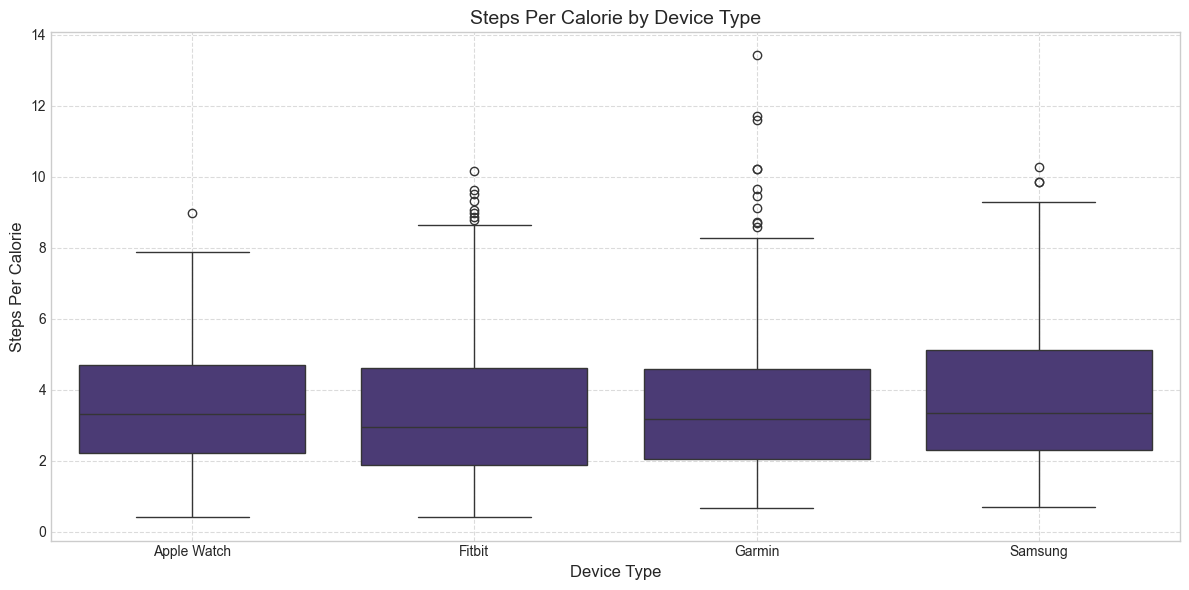

In [26]:
# 6. Steps Per Calorie by Device Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Device_Type', y='Steps_Per_Calorie', data=cleaned_df)
plt.title('Steps Per Calorie by Device Type', fontsize=14)
plt.xlabel('Device Type', fontsize=12)
plt.ylabel('Steps Per Calorie', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('visualizations/steps_per_calorie_by_device.png', dpi=300)
plt.show()

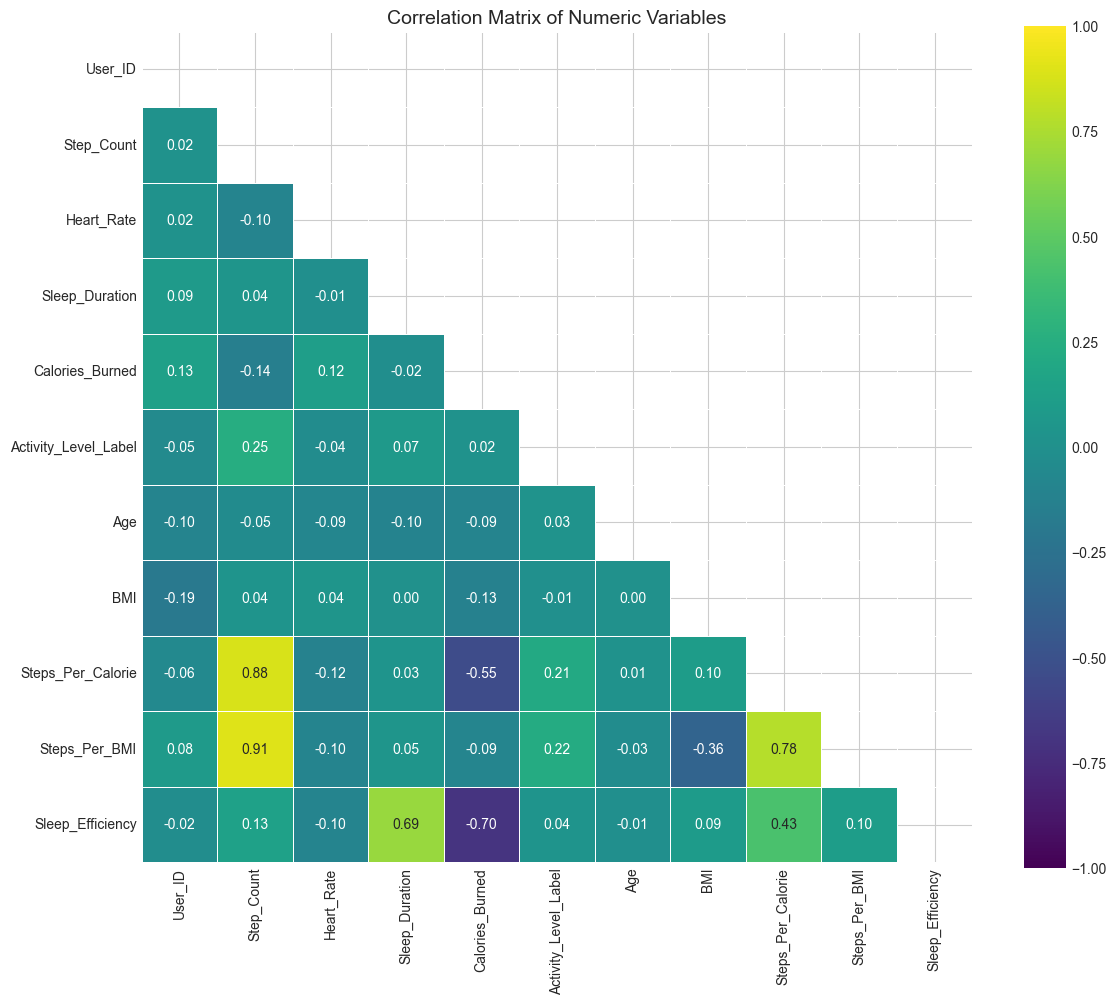

In [27]:
# 7. Correlation Matrix
plt.figure(figsize=(12, 10))
# Select only numeric columns
numeric_df = cleaned_df.select_dtypes(include=[np.number])
# Calculate correlation matrix
corr = numeric_df.corr()
# Create heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='viridis', 
            vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables', fontsize=14)
plt.tight_layout()
plt.savefig('visualizations/correlation_matrix.png', dpi=300)
plt.show()


